In [3]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.linalg import eig
from scipy.stats import skew, skewtest, percentileofscore

import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("../functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots
#import modelandmetrics

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [4]:
imp.reload(preprocessing)
imp.reload(experiment_settings)
imp.reload(build_model)
imp.reload(metricplots)
imp.reload(allthelinalg)
imp.reload(analysisplots)

<module 'analysisplots' from '/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/supplemental/../functions/analysisplots.py'>

In [5]:
modelpath = "../models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec = np.arange(1870+2*run+leadtime,2023,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [6]:
datafile = "../processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))

conversion done


In [7]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)
lenobs = inputobs_ERSST.shape[0]

In [8]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelpearsons

def model_member_err(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):

    modelerrs = np.empty((nmodels,nvariant))
    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelerrs[imodel,imem] = allthelinalg.err_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelerrs[imodel,imem] = allthelinalg.err_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelerrs                                                                                                

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

In [9]:
domainMSE = []
SCMSE = []

for random_seed in seedlist:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN

    y_pred_val = full_model.predict(inputval) 
    
    bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   
    SCtimeseries_true = allthelinalg.index_timeseries(outputval,bestpattern,landmask)
    SCtimeseries_pred = allthelinalg.index_timeseries(y_pred_val,bestpattern,landmask)
    SCtimeseries_err = np.mean((SCtimeseries_true-SCtimeseries_pred)**2)
    
    mse = weightedMSE(y_pred_val,outputval,latweights)
    domainMSE.append(mse)
    SCMSE.append(mse)

domainMSE = np.asarray(domainMSE)
bestseed = np.argmin(domainMSE)

336/336 [==============================] - 1s 4ms/step


In [10]:
imp.reload(analysisplots)
#for random_seed in seedlist[1:2]:

random_seed = seedlist[bestseed]

fileout = filename + "_seed=" + str(random_seed) +".h5"

tf.random.set_seed(random_seed)
np.random.seed(random_seed) 

full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                experiment_dict, random_seed)  

full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                    loss=tf.keras.losses.MeanSquaredError(), 
                  )

full_model.load_weights(fileout)

full_model.trainable = False # freeze BN

y_pred_test = full_model.predict(inputtest)
y_pred_val = full_model.predict(inputval) 

bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   

336/336 [==============================] - 1s 3ms/step


In [47]:
SCpatterns = []

for imem in range(9*7):
    SCtimeseries_loop = allthelinalg.index_timeseries(outputtest[imem*ntimesteps:(imem+1)*ntimesteps,:,:],bestpattern,landmask)
    SCpattern_loop = np.mean(outputtest[imem*ntimesteps:(imem+1)*ntimesteps,:,:]*SCtimeseries_loop[:,np.newaxis,np.newaxis],axis=0)
    SCpattern_loop = np.squeeze(SCpattern_loop*outputstd)

    SCpatterns.append(SCpattern_loop)

SCpatterns = np.asarray(SCpatterns)
SCpatterns.shape

(63, 11, 38)

In [63]:
obsSCtimeseries = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)
obsSCpattern = np.mean(outputobs_ERSST*obsSCtimeseries[:,np.newaxis,np.newaxis],axis=0)
obsSCpattern = np.squeeze(obsSCpattern*outputstd)
obsSCpattern.shape

(11, 38)

In [92]:
score = np.empty((11,38))+np.nan

for ilat in range(11):
    for ilon in range(38):

        score[ilat,ilon] = percentileofscore(SCpatterns[:,ilat,ilon],SCpatterns[50,ilat,ilon])

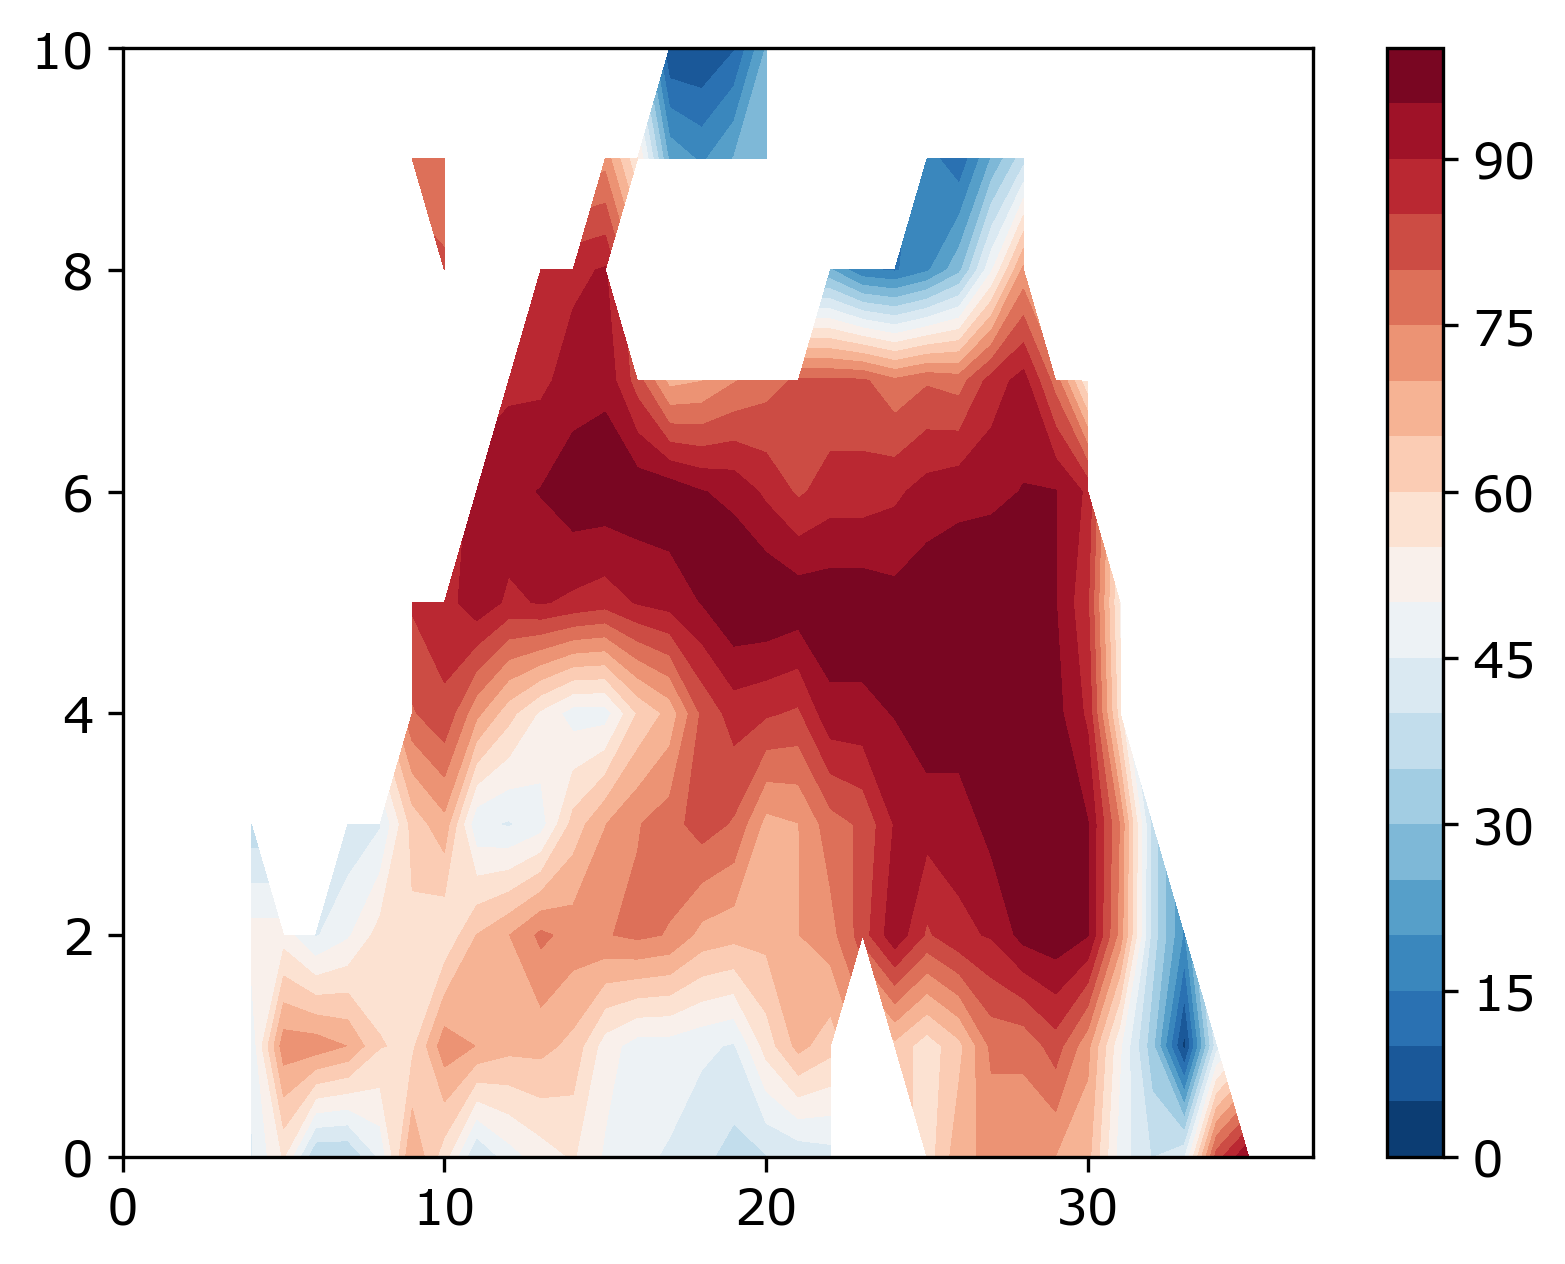

In [93]:
plt.contourf(score,np.arange(0,105,5),cmap="RdBu_r")
plt.colorbar()

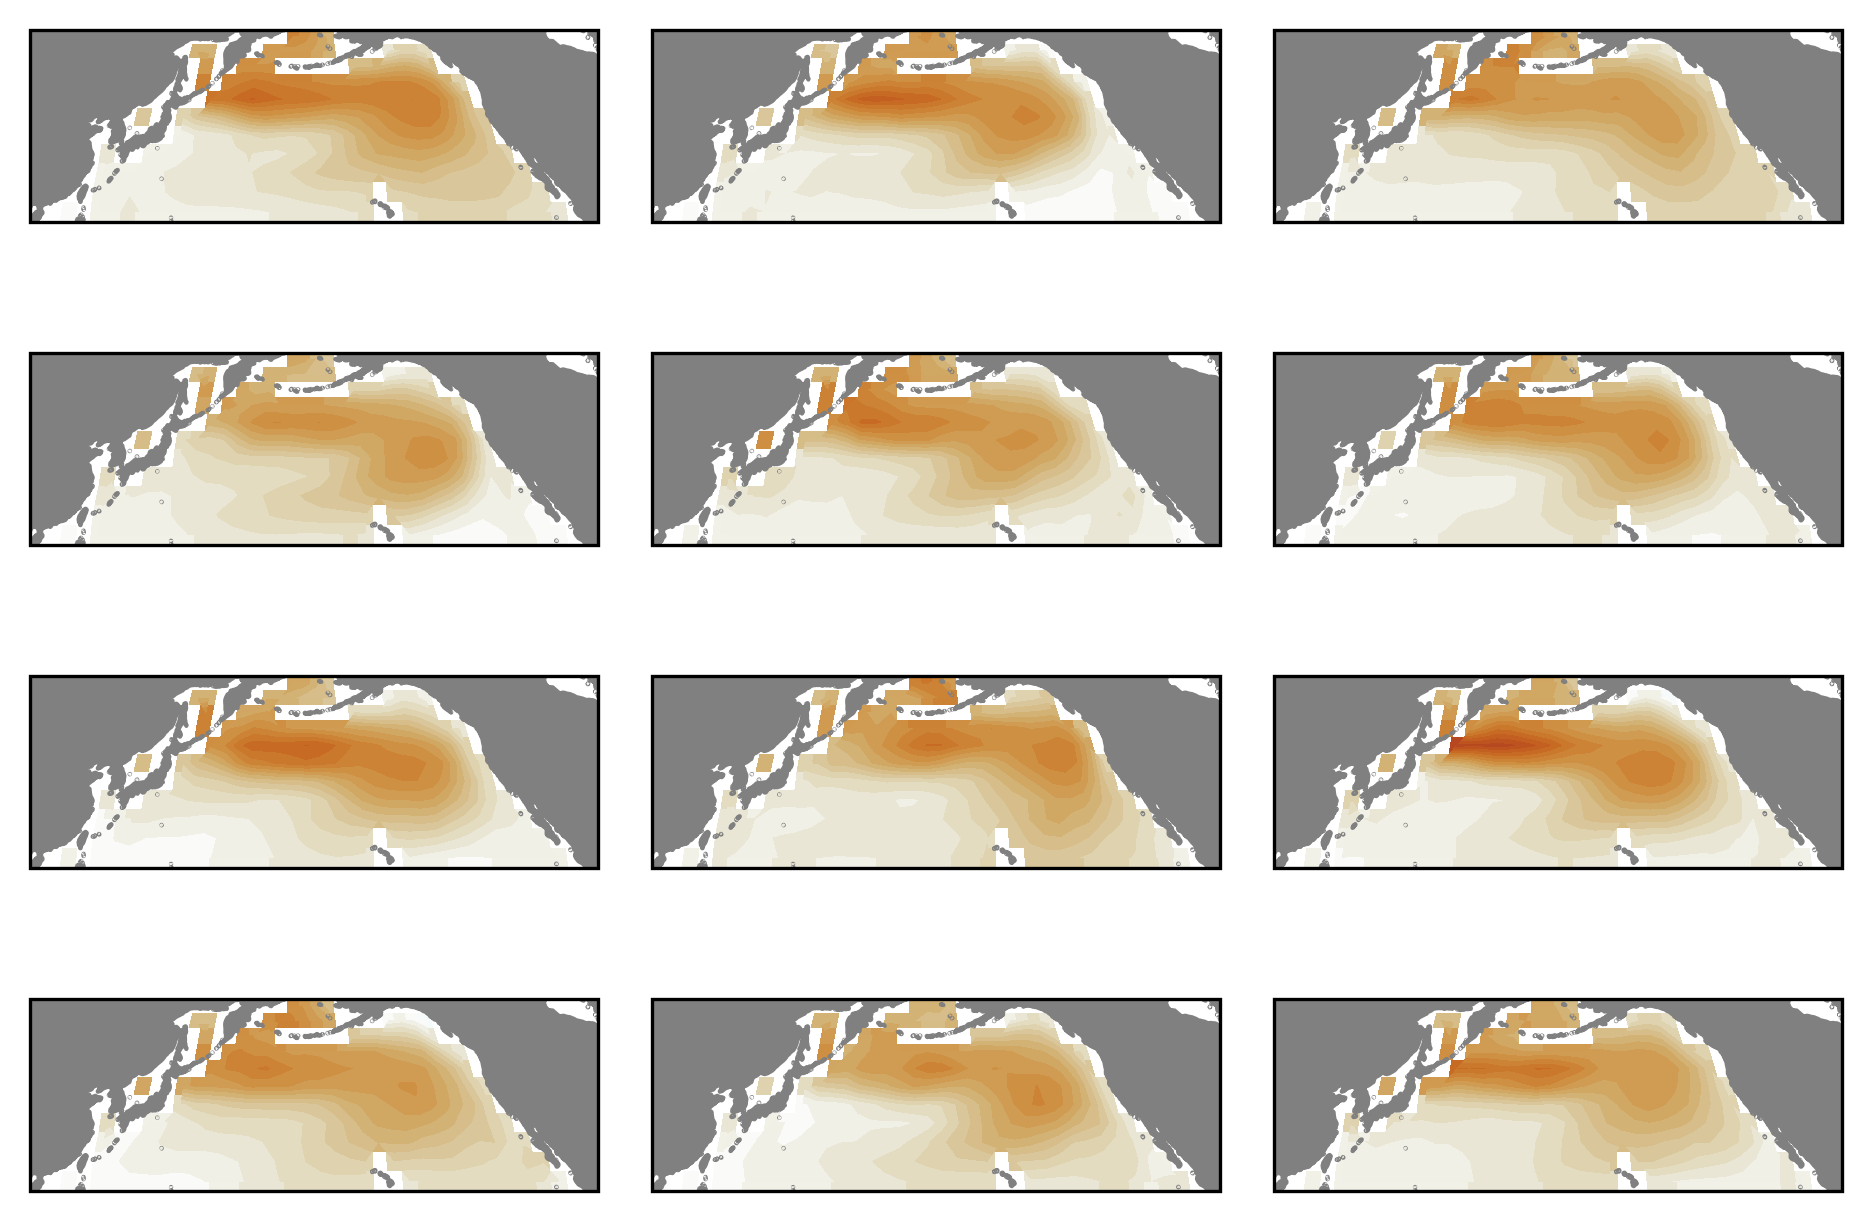

In [12]:
imp.reload(analysisplots)
nboots = 12

alloutputtest = outputtest.shape[0]

lbound = -0.6
ubound = 0.6

cmapdiff = cmr.fusion_r
boundsdiff = np.arange(lbound,ubound+0.02,0.02)
normdiff = colors.BoundaryNorm(boundaries=boundsdiff, ncolors=cmapdiff.N)
    
# plt.figure(figsize=(18,10))

# SC_pattern_all = []

for iboot in range(nboots):
    indsel = np.random.choice(alloutputtest,lenobs,replace=False)
    SCtimeseries_loop = allthelinalg.index_timeseries(outputtest[indsel,:,:],bestpattern,landmask)
    SCpattern_loop = np.mean(outputtest[indsel,:,:]*SCtimeseries_loop[:,np.newaxis,np.newaxis],axis=0)
    SCpattern_loop = np.squeeze(SCpattern_loop*outputstd)

    # SC_pattern_all.append(SCpattern_loop)
    a1=plt.subplot(4,3,iboot+1,projection=ccrs.EqualEarth(central_longitude=180))
    a1.pcolormesh(lon,lat,SCpattern_loop,norm=normdiff,cmap=cmapdiff,transform=ccrs.PlateCarree())
    c1=a1.contourf(lon,lat,SCpattern_loop,boundsdiff,cmap=cmr.fusion_r,transform=ccrs.PlateCarree(),extend='both')
    a1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
    # a1.coastlines()
    # cbar=plt.colorbar(c1)
    # cbar.ax.set_ylabel(r'SST ($^{\circ}$C)')
    # cbar.ax.set_yticks(np.arange(lbound,ubound+0.1,0.1))

plt.tight_layout()

# SC_pattern_all = np.asarray(SC_pattern_all)

# SC_pattern_std = np.std(SC_pattern_all,axis=0)

# a1=plt.subplot(1,1,1,projection=ccrs.EqualEarth(central_longitude=180))
# a1.pcolormesh(lon,lat,3*SC_pattern_std,vmin=0,vmax=0.3,cmap="inferno",transform=ccrs.PlateCarree())
# # c1=a1.contourf(lon,lat,SC_pattern_all,boundsdiff,cmap=cmr.fusion_r,transform=ccrs.PlateCarree(),extend='both')
# a1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
#     # a1.coastlines()
#     # cbar=plt.colorbar(c1)
#     # cbar.ax.set_ylabel(r'SST ($^{\circ}$C)')
#     # cbar.ax.set_yticks(np.arange(lbound,ubound+0.1,0.1))

# plt.tight_layout()


